To work with mlp mixer, you need to clone my repository, all packeges I wrote in there

You can easily run the ipynb via https://www.kaggle.com/oguzhanercan/mlp-mixer-cifar10-classification

In [ ]:
# !git clone https://github.com/Oguzhanercan/MLP-Mixer

# Import Libraries and packages

In [1]:
import torch
from torch import nn
from PIL import Image
import numpy as np
import einops
import os 
import pandas as pd
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
param_path= "model.pt"

Below I import my mlp mixer implementation.

In [3]:
from mlp_mixer import mlp_mixer as mm

We are dealing with multi-class image classification, so we use Cross Entropy Loss function.

In [4]:
criterion = nn.CrossEntropyLoss()

The MLP-Mixer paper suggest the patch size as 16. But we are dealing with 32x32 images. So if we use patch size as 16, there will be 4 patches. In this case the attention queries will be to small, the most important parameter for this model. 

In [5]:
def create_model(patch_size):
 return  mm.Mixer(
        num_classes= 10,
        img_size= 32,
        patch_size=patch_size)

initialization of parameters

In [6]:
def init_params(path):
    model.load_state_dict(torch.load(path,map_location=dvc))


Creating selected optimizer, I offer 2 different optimizers.

In [7]:
def create_optimizer(optimizer_name,lr):
    if optimizer_name == "Adam":
        return torch.optim.Adam(model.parameters(),lr = lr,betas = (0.9,0.999),weight_decay=0.3)
    else:
        return torch.optim.SGD(model.parameters(),lr = lr)


Train validation and test datasets will be created on the next cell.

In [8]:
def create_data_loaders(valid_per,batch_size,num_workers):

    transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    test_transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    train_dataset = torchvision.datasets.CIFAR10(root='/home/computer/Desktop/mind/Machine_learning/MLP_Mixer', train=True,transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='/home/computer/Desktop/mind/Machine_learning/MLP_Mixer', train=False,transform=test_transform)

    indices = torch.randperm(len(train_dataset))
    split = int(np.floor((valid_per)*(len(train_dataset))))
    t_idx, v_idx = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(v_idx)
    val_sampler = SubsetRandomSampler(t_idx)

    trainloader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(
                train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, sampler=val_sampler)
    testloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,drop_last=True)

    return trainloader,validloader,testloader


The function below saves the state of losses of the training process 

In [9]:
def save_loss_state(loss_train,loss_valid,checkpoints):
    train = open("train_loss_state.txt","w")
    train.write(str(loss_train))
    train.close()
    valid = open("valid_loss_state.txt","w")
    valid.write(str(loss_valid))
    valid.close()
    check = open("check_state.txt","w")
    check.write(str(loss_train))
    check.close()

The train function that optimizes the parameters of the model.

In [10]:
def train():
    check_points = []
    loss_train = []
    loss_valid = []
    valid_loss_min = np.Inf
    
    for i in tqdm(range(epoch_widget.value)):
        print("Epoch - {} Started".format(i+1))

        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for data, target in trainloader:
            data, target = data.to(dvc), target.to(dvc)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)

        model.eval()
        for data, target in validloader:
            data, target = data.to(dvc), target.to(dvc)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(trainloader.sampler)
        valid_loss = valid_loss/len(validloader.sampler)
        loss_train.append(train_loss)
        loss_valid.append(valid_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            i+1, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            check_points.append(i)
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
    save_loss_state(loss_train,loss_valid,check_points)

The test function that calculates the accuracy of the model.

In [11]:
def test(loader):
    model.eval()
    with torch.no_grad():
        total = 0
        correct =0
        for images, labels in loader:
            images = images.to(dvc)
            labels = labels.to(dvc)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Accuracy : {} %'.format(100 * correct / total))


The predict function that takes an image and returns the predicted class.

In [12]:
def predict(images):
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(f"prediction {predicted}")

The function below extracts the number of samples that belongs to the each class.

In [13]:
def class_dist(dataset,num_class):
    counter = np.ones(num_class)
    for i in dataset:
        counter[i[1]]+=1
    return counter


The function below visualizes a pie chart that contains informations about class distribution.

In [14]:
def class_histogram(counter):
    plt.title("Class Distribution")
    labels = np.arange(len(counter))
    plt.pie(counter,labels = labels,wedgeprops={"edgecolor":"black"},shadow=True,autopct="%1.1f%%")
    plt.tight_layout()
    plt.show( )

The function below visualizes a line plot about the training loss and also visualizes a scatter&line plot mix that contains training loss, validation loss and checkpoints.

In [15]:
def loss_analyze(train_loss,val_loss,check_points):
    plt.style.use('seaborn')
    lt = np.arange(len(train_loss))
    ltc = []
    for i in check_points:
        ltc.append(val_loss[i])
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    ax1.plot(lt, train_loss, color='#444444',
            linestyle='--', label='Train Loss')


    ax2.plot(lt, train_loss, label='Train Loss')
    ax2.plot(lt, val_loss, label='Validation Loss')
    ax2.scatter(check_points,ltc,label = "Check Points")
    

    ax1.legend()

    ax1.set_title('Train Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
   
    ax2.legend()

    ax2.set_title('Train - Validation Loss with check points')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

  

    plt.tight_layout()

    plt.show()

Hyper parameter settings widgets

In [16]:
lr_widget = widgets.FloatSlider(
    value=0.0003,
    min=0,
    max=0.2,
    step=0.0001,
    description='Learning Rate',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
)
bs_widget = widgets.IntSlider(
    value=8,
    min=1,
    max=32,
    step=1,
    description='Batch Size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
patch_s_widget = widgets.IntSlider(
    value=8,
    min=4,
    max=32,
    step=4,
    description='Patch size of MLP-Mixer',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
valid_per_widget = widgets.FloatSlider(
    value=0.2,
    min=0.1,
    max=0.9,
    step=0.1,
    description='% of Val',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
num_workers_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=5,
    step=1,
    description='Num Workers',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)


In [17]:
caption = widgets.Label(value='Set Hyper Parameters')
widgets.VBox([caption,valid_per_widget, patch_s_widget,lr_widget,bs_widget,num_workers_widget])


In [18]:
valid_per,batch_size,num_workers,lr,patch_s = valid_per_widget.value,bs_widget.value,num_workers_widget.value,lr_widget.value,patch_s_widget.value

The cell below provides a widget to choose the device for computations.

In [19]:
def f(device):
    global dvc
    if device == "cuda" and torch.cuda.is_available(): 
        dvc = "cuda"
        print("Device selected as cuda")
        return "cuda"
    elif device == "cuda":
        dvc = "cpu"
        print("Device selected as cpu, cuda is not avaliable")
        return "cpu"
    else:
        dvc = "cpu"
        print("Device selected as cpu")
        return "cpu"
device_widget = interact(f, device=['cuda','cpu'])

interactive(children=(Dropdown(description='device', options=('cuda', 'cpu'), value='cuda'), Output()), _dom_c…

Create and initiliaze the model.

In [20]:
model = create_model(patch_s)
init_params(param_path)

Create the optimizer.

In [21]:
def op(Optimizer):
    print("Optimizer selected as "+Optimizer)
    global optimizer 
    optimizer = create_optimizer(Optimizer,lr)
    return Optimizer
optimizer_widget = interact(op, Optimizer=['Adam','SGD']);

interactive(children=(Dropdown(description='Optimizer', options=('Adam', 'SGD'), value='Adam'), Output()), _do…

The widget below lets the user to choose epoch number to train and validate.

In [22]:
epoch_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    step=1,
    description='Epoch number',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
epoch_widget

IntSlider(value=1, continuous_update=False, description='Epoch number', min=1, readout_format='.0f')

Create the dataloaders.

In [23]:
trainloader, validloader, testloader = create_data_loaders(valid_per,batch_size,num_workers)

Files already downloaded and verified


Train the model.

In [24]:
train()

The cell below provides a widget to choose a dataset for the purpose of calculating accuracy.

In [24]:
def op(dataset):
    global data2test
    
    if(dataset == "train"):
        data2test = trainloader
        print("Dataset selected as ")
        return dataset
    elif(dataset == "validation"):
        data2test = validloader
        print("Dataset selected as ")
        return dataset
    else:
        data2test = testloader
        print("Dataset selected as ")
        return dataset
test_widget = interact(op, dataset=['test','validation','train']);


interactive(children=(Dropdown(description='dataset', options=('test', 'validation', 'train'), value='test'), …

In [25]:
test(data2test) # Test Dataset

Accuracy : 71.0 %


LOSS, Train Validation Trade-off, Checkpoints

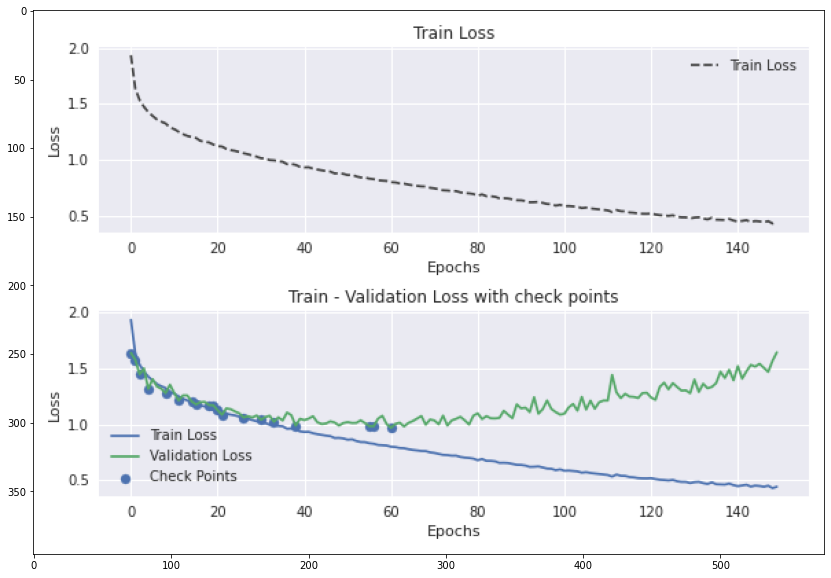

In [28]:
img = Image.open("fig.png") # the result of loss_analyze function
plt.figure(figsize=(20,10))
plt.imshow(img)
